In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = ""

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
count_train = 0
for i in cities:
    city = i  
    split = 'train'
    train_dataset  = ArgoverseDataset(city = city, split = split)
    count_train += len(train_dataset)
print("the number of training data:" + str(count_train))

count_test = 0
for i in cities:
    city = i  
    split = 'test'
    test_dataset  = ArgoverseDataset(city = city, split = split)
    count_test+= len(test_dataset)
print("the number of training data:" + str(count_test))

the number of training data:203816
the number of training data:29843


In [5]:
# convert the original training document into trainable batches 
def get_batches_x(inp, batch_size):
    
    
    num_batches = int(len(inp) / (batch_size))
    
    X = inp[:num_batches*batch_size]
#     Y = np.zeros((len(X), 50))
    
    X = X[:, :, 0]
    
    # generate trainable batches
    for i in range(0, num_batches*batch_size, batch_size):
        Xs = []
        Ys = []
        for j in range(i, i+batch_size):
            temp_x = X[j][:-1]
               
            temp_y = X[j][1:]
            
            Xs.append(temp_x)
            Ys.append(temp_y)
        
        Xs = np.array(Xs)
        Ys = np.array(Ys)

        yield torch.tensor(Xs).float(), torch.tensor(Ys).float()

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN_new_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN_new_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encode1 = nn.Linear(input_size, hidden_size)
        # input tensor - (batch, seq, tensor)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2, num_layers=n_layers, batch_first=True, bidirectional=True)
        
        self.encode2 = nn.Linear(input_size, hidden_size)
        
        self.encode3 = nn.Linear(hidden_size, hidden_size * 2)
        
        self.encode4 = nn.Linear(hidden_size * 2, hidden_size // 2)
        
        self.encode5 = nn.Linear(input_size, hidden_size // 2)
        
        self.encode6 = nn.Linear(hidden_size//2, output_size)
        
        
        self.decoder = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

#         self.encode1 = nn.Embedding(61, (hidden_size-10)//2)
#         self.encode2 = nn.Embedding(max_frequency+1, (hidden_size-10)//2)
#         self.encode3 = nn.Embedding(5, 10)
        

    def forward(self, x_input, prev_hidden_and_cell, temperature=1.0):
        
        encode1 = self.encode1(x_input)

        output, (hidden, cell) = self.lstm(encode1.unsqueeze(1), prev_hidden_and_cell)
#         print(output.shape)
        encode2 = self.encode2(x_input)
        bi_output, (hidden, cell) = self.lstm(encode2.unsqueeze(1), prev_hidden_and_cell)
#         print(bi_output.shape)
        f_output = torch.tanh(self.encode3(output + bi_output))
#         print(f_output.shape)
        f_output1 = torch.tanh(self.encode4(f_output))
#         print(f_output1.shape)
        f_output2 = self.encode5(x_input)
#         print(f_output2.shape)
#         print(f_output1.shape)
#         print((f_output1 + f_output2).shape)
        
        f_output2 = f_output2.reshape(f_output2.shape[0], 1, f_output2.shape[1])
#         print(f_output2.shape)
#         print((f_output1 + f_output2).shape)
#         print(f_output1.shape)
        output = self.encode6(f_output1 + f_output2)
        output = output.reshape(len(output), 1)
#         print(output)
#         print(output)
#         print(output.shape)
#         output = self.decoder(output.reshape(output.shape[0], -1))

#         print(output)
#         print(output)
#         print(output.shape)
#         output = self.softmax(output / temperature)
#         output = defined_softmax(output.reshape(1, 1, 61), temperature)

        return output, (hidden, cell)
    
    def forward1(self, input_char_idx, input_char_freq, input_char_syllable, prev_hidden_and_cell, temperature=1.0):

        encode1 = self.encode1(input_char_idx)
        encode2 = self.encode2(input_char_freq)
        encode3 = self.encode3(input_char_syllable)
        
        encode = torch.cat((encode1, encode2, encode3), 1)

        output, (hidden, cell) = self.lstm(encode.unsqueeze(1), prev_hidden_and_cell)

        output = self.decoder(output.reshape(output.shape[0], -1))

        output = self.softmax(output / temperature)
#         output = defined_softmax(output, temperature)


        return output, (hidden, cell)

    def init_state(self, batch_size):
        # return the initial hidden state and cell state
        return torch.zeros(self.input_size, batch_size, self.hidden_size), torch.zeros(self.input_size, batch_size, self.hidden_size)

In [8]:
def train_model(inp, n_epochs, hidden_size, batch_size, seq_size, lr, temperature):
    
    # (input_size/feature dim, num of characters, hidden_size, output_size, n_layers=1)
    model = RNN_new_1(1, hidden_size, 1, 1)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    avg_loss_over_time = []
    for epoch in range(n_epochs):
        batches = get_batches_x(inp, batch_size)

        hidden, cell = model.init_state(batch_size)

        i = 0
        print("new epoch starts, currently at " + str(epoch) + " epoch")
        
        loss_avg = 0
        
        for X, Y in batches:
            i += 1

            # Reset all gradients
            optimizer.zero_grad()
            
            loss = 0
                         
            for i in range(seq_size-1):
                temp_x = X[:, i]
                temp_y = Y[:, i]
                output, (hidden, cell) = model.forward(temp_x.reshape(batch_size, 1), (hidden, cell), temperature)
#                 print(output)
#                 print(output.shape)
                loss += criterion(output, temp_y.reshape(batch_size, 1))
            
            hidden = hidden.detach()
            cell = cell.detach()
            
            loss.backward(retain_graph=True)
            optimizer.step()
            loss_avg += loss.item() / seq_size
            
        avg_loss_over_time.append(math.sqrt(loss_avg / i))   
        print("avg loss at " + str(i) + "th iteration - " + str(math.sqrt(loss_avg / i)))
        print("\n")  
    
    
    plt.plot(avg_loss_over_time)
    plt.xlabel("epoch num")
    plt.ylabel("avg_loss")
    return model

In [19]:
import time
import math

In [13]:
p_i, p_o = get_city_trajectories(city="palo-alto", split="train", normalized=True)

In [14]:
train_combined = np.concatenate([p_i, p_o], axis=1)

In [15]:
train_combined.shape

(11993, 110, 2)

In [ ]:
temp_mean, temp_std = np.mean(train_combined[:, :, 0].reshape(-1)), np.std(train_combined[:, :, 0].reshape(-1))
normalized = (train_combined[:, :, 0].reshape(-1) - temp_mean) / temp_std

Starts training process
new epoch starts, currently at 0 epoch
avg loss at 108th iteration - 269.03168453555486


new epoch starts, currently at 1 epoch
avg loss at 108th iteration - 55.332928648415056


new epoch starts, currently at 2 epoch
avg loss at 108th iteration - 16.369735432711952


new epoch starts, currently at 3 epoch
avg loss at 108th iteration - 5.7912167561985095


new epoch starts, currently at 4 epoch
avg loss at 108th iteration - 1.7501580651822426


new epoch starts, currently at 5 epoch
avg loss at 108th iteration - 0.668172156090779


new epoch starts, currently at 6 epoch
avg loss at 108th iteration - 0.42926282995899023


new epoch starts, currently at 7 epoch
avg loss at 108th iteration - 0.40180785835295446


new epoch starts, currently at 8 epoch
avg loss at 108th iteration - 0.3930175955172718


new epoch starts, currently at 9 epoch
avg loss at 108th iteration - 0.38746986126940586


Ends training process, total time - 683.1844065189362


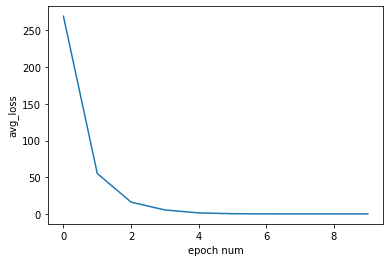

In [20]:
# (inp, n_epochs, hidden_size, batch_size, seq_size, lr, temperature)
start = time.time()
print("Starts training process")
model_1 = train_model(train_combined, 10, 64, 500, 110, 0.05, 1.5)
end = time.time()
print("Ends training process, total time - " + str(end - start))

In [21]:
def predict(model, inp, predict_length):

    hidden, cell = model.init_state(1)
    
    
    input_batch = get_batches_x(inp.reshape(1,len(inp),2), 1)

    X, _ = next(input_batch)
    
    # build upon our hidden and cell state based on the first seq_size-1 positions
    for i in range(len(inp)-1):
        temp_x = X[:, i]
#         print(temp_x)
        output, (hidden, cell) = model.forward(temp_x.reshape(1, 1), (hidden, cell), 1)
#         print(output)

    prev = inp[-1][0]
#     print(prev)
    predict = []
    # make the prediction character by character
    for _ in range(predict_length):
        
        temp_x = torch.tensor([prev]).float()

        output, (hidden, cell) = model.forward(temp_x.reshape(1,1), (hidden, cell), 1)

#         output = defined_softmax(output.reshape(1, 1, 61), temperature)

        prev = output[0]

        predict.append(prev)


    return predict